In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import muon as mu
import anndata as ad
from muon import prot as pt
import squidpy as sq
import scanpy as sc
import plotnine as p9

/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import liana as li
from liana.method import MistyData
li.__version__

'1.0.0a0'

In [3]:
# human tonsil
rna_path = "data/GSE213264/GSM6578062_humantonsil_RNA.tsv.gz"
prot_path = "data/GSE213264/GSM6578071_humantonsil_protein.tsv.gz"

# human thymus
#rna_path = "data/GSE213264/GSM6578064_humanthymus_RNA.tsv.gz"
#prot_path = "data/GSE213264/GSM6578073_humanthymus_protein.tsv.gz"

# human skin
#rna_path = "data/GSE213264/GSM6578065_humanskin_RNA.tsv.gz"
#prot_path = "data/GSE213264/GSM6578074_humanskin_protein.tsv.gz"

# mouse kidney
#rna_path = "data/GSE213264/GSM6578061_mousekidney_RNA.tsv.gz"
#prot_path = "data/GSE213264/GSM6578070_mousekidney_protein.tsv.gz"

# mouse spleen
#rna_path = "data/GSE213264/GSM6578058_mousespleen_RNA.tsv.gz"
#prot_path = "data/GSE213264/GSM6578067_mousespleen_protein.tsv.gz"

In [4]:
rna = pd.read_csv(rna_path, sep="\t")
prot_orig = pd.read_csv(prot_path, sep="\t")
prot = prot_orig.copy()
prot_orig.columns = [re.sub("\\.[AGCT]{15}", "", s) for s in prot_orig.columns]
assert set(rna.X) == set(prot.X)

rna = rna.set_index("X")
prot = prot.set_index("X")
prot_orig = prot_orig.set_index("X")
prot = prot.loc[rna.index]
prot_orig = prot_orig.loc[rna.index]
assert np.all(rna.index == prot.index)
assert np.all(rna.index == prot_orig.index)

In [5]:
# get coordinates
def get_coord(col):
    x_coord = [s.split("x")[0] for s in col]
    y_coord = [s.split("x")[1] for s in col]
    df_coord = pd.DataFrame({"x": x_coord, "y": y_coord})
    df_coord = df_coord.apply(pd.to_numeric)
    return df_coord
coord = get_coord(rna.index)

obs_df = rna.index.to_frame(name="name")
obs_df["x"] = coord["x"].to_numpy()
obs_df["y"] = coord["y"].to_numpy()

spatial = obs_df.copy().loc[:, ["x", "y"]]
spatial

,x,y
X,,
29x42,29,42
44x36,44,36
34x6,34,6
42x19,42,19
41x6,41,6
...,...,...
2x26,2,26
30x26,30,26
23x48,23,48


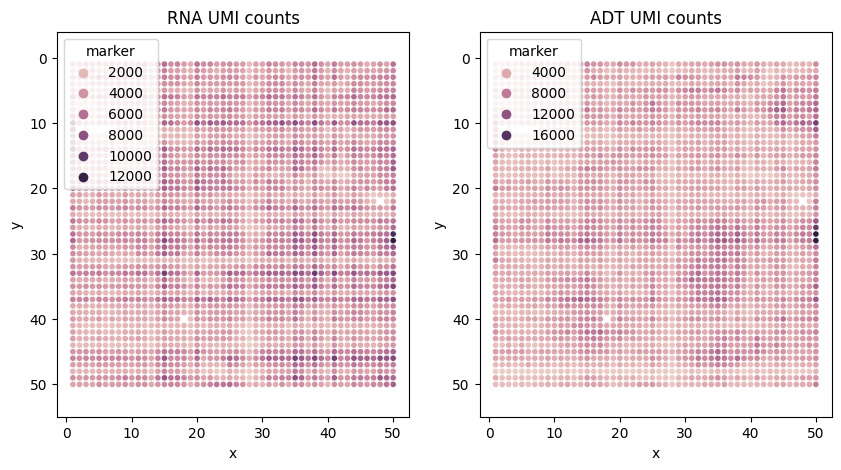

In [6]:
# QC plots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plot_df = spatial.copy()
plot_df["marker"] = rna.sum(axis=1)
sns.scatterplot(x='x', y='y', hue='marker', data=plot_df, ax=axs[0], s=20)
axs[0].axis('equal')
axs[0].invert_yaxis()
axs[0].set_title("RNA UMI counts")

plot_df = spatial.copy()
plot_df["marker"] = prot_orig.sum(axis=1)
sns.scatterplot(x='x', y='y', hue='marker', data=plot_df, ax=axs[1], s=20)
axs[1].axis('equal')
axs[1].invert_yaxis()
axs[1].set_title("ADT UMI counts")
plt.show()

In [7]:
# remove spike ins from rna
print(rna.shape)
spike_bool = np.array(["ERCC" in c for c in rna.columns])
print(spike_bool.sum())
rna = rna.loc[:,~spike_bool]
print(rna.shape)

# remove unmapped from protein
print(prot.shape)
unmapped_bool = np.array(["unmapped" in c for c in prot.columns])
print(unmapped_bool.sum())
prot = prot.loc[:,~unmapped_bool]
print(prot.shape)

(2492, 28417)
29
(2492, 28388)
(2492, 283)
1
(2492, 282)


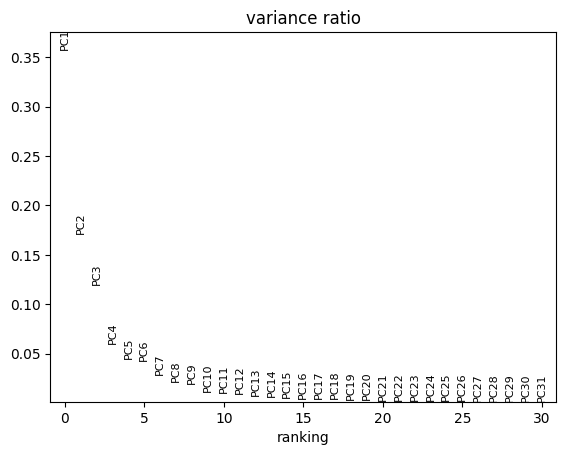

/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


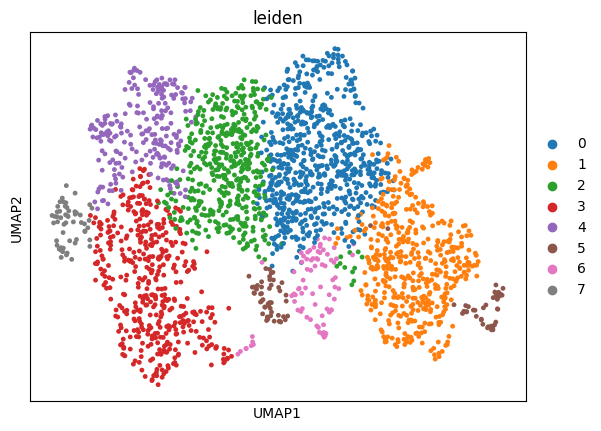

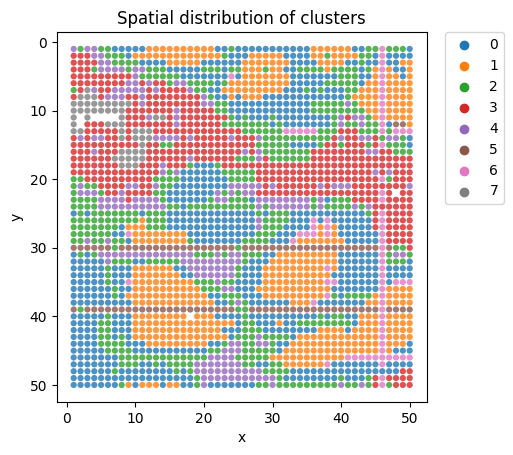

In [8]:
prot_ad = sc.AnnData(X=prot.values.copy(), obs=prot.index.to_frame(name="id"), var=prot.columns.to_frame(name="protein"), obsm={"spatial": spatial})
sc.pp.normalize_total(prot_ad, target_sum=1e4)
sc.tl.pca(prot_ad, svd_solver='arpack')
sc.pl.pca_variance_ratio(prot_ad)
sc.pp.neighbors(prot_ad, n_neighbors=10, n_pcs=20)
sc.tl.leiden(prot_ad, resolution=0.4)
sc.tl.umap(prot_ad)

sc.pl.umap(prot_ad, color=["leiden"])

plot_df = prot_ad.obsm["spatial"].copy()
plot_df["marker"] = prot_ad.obs["leiden"].values
# make scatter plot using seaborn
sns.scatterplot(data=plot_df,x="x",y="y",hue="marker", s=20, alpha=0.8)
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("Spatial distribution of clusters")
plt.show()

AnnData object with n_obs × n_vars = 2492 × 28388
    obs: 'id'
    var: 'gene'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2492 × 10087
    obs: 'id'
    var: 'gene', 'n_cells'
    obsm: 'spatial'


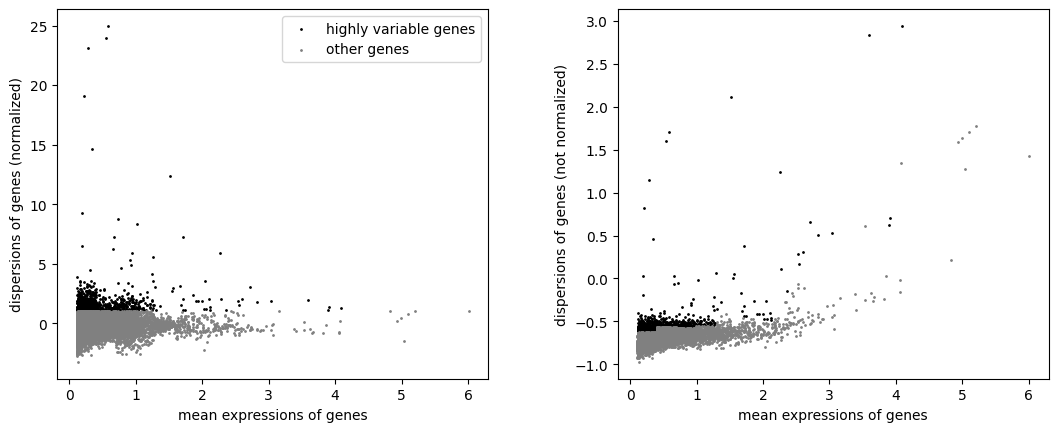

View of AnnData object with n_obs × n_vars = 2492 × 1000
    obs: 'id'
    var: 'gene', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'
    obsp: 'spatial_connectivities'


/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.


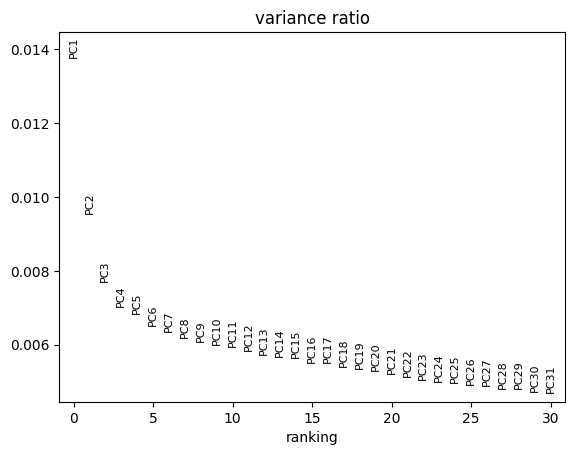

AnnData object with n_obs × n_vars = 2492 × 1000
    obs: 'id'
    var: 'gene', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'spatial_connectivities'


/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


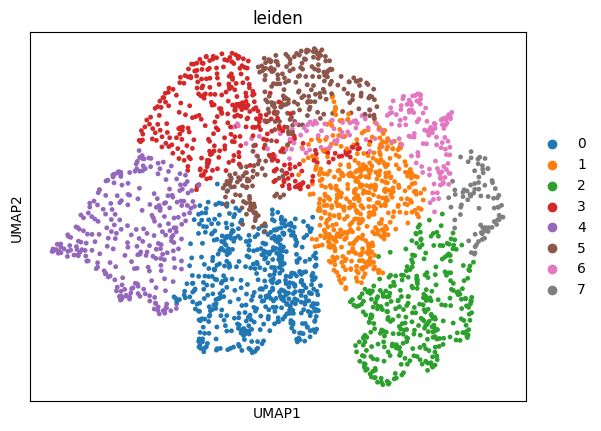

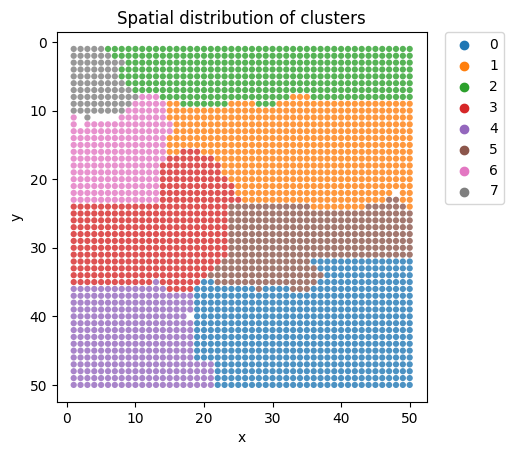

In [29]:
rna_ad = sc.AnnData(X=rna.values.copy(), obs=rna.index.to_frame(name="id").copy(), var=rna.columns.to_frame(name="gene").copy(), obsm={"spatial": spatial.copy()})
print(rna_ad)

# filter
sc.pp.filter_genes(rna_ad, min_cells=100)
print(rna_ad)

# check
#sc.pl.highest_expr_genes(rna_ad, n_top=20)

li.ut.spatial_neighbors(rna_ad, bandwidth=0.75, cutoff=0, set_diag=True)
li.pl.connectivity(rna_ad, idx=0)

# smooth the expression in space
rna_ad.X = rna_ad.obsp["spatial_connectivities"]@rna_ad.X

# normlaize
sc.pp.normalize_total(rna_ad, target_sum=1e4)
sc.pp.log1p(rna_ad)

# get hvg
sc.pp.highly_variable_genes(rna_ad, n_top_genes=1000, flavor="seurat")
#sc.pp.highly_variable_genes(rna_ad, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(rna_ad)
rna_ad = rna_ad[:, rna_ad.var["highly_variable"]]
print(rna_ad)

# sclae and pca
sc.pp.scale(rna_ad, max_value=10)
sc.tl.pca(rna_ad, svd_solver='arpack')
sc.pl.pca_variance_ratio(rna_ad)
print(rna_ad)

# clustering
sc.pp.neighbors(rna_ad, n_neighbors=20, n_pcs=20)
sc.tl.leiden(rna_ad, resolution=0.4)
sc.tl.umap(rna_ad)
sc.pl.umap(rna_ad, color=["leiden"])

# plotting
plot_df = rna_ad.obsm["spatial"].copy()
plot_df["marker"] = rna_ad.obs["leiden"].values
sns.scatterplot(data=plot_df, x="x", y="y", hue="marker", linewidth=0, s=20, alpha=0.8)
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("Spatial distribution of clusters")
plt.show()

AnnData object with n_obs × n_vars = 2492 × 28388
    obs: 'id'
    var: 'gene'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2492 × 10087
    obs: 'id'
    var: 'gene', 'n_cells'
    obsm: 'spatial'
View of AnnData object with n_obs × n_vars = 2492 × 2500
    obs: 'id'
    var: 'gene', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'hvg'
    obsm: 'spatial'


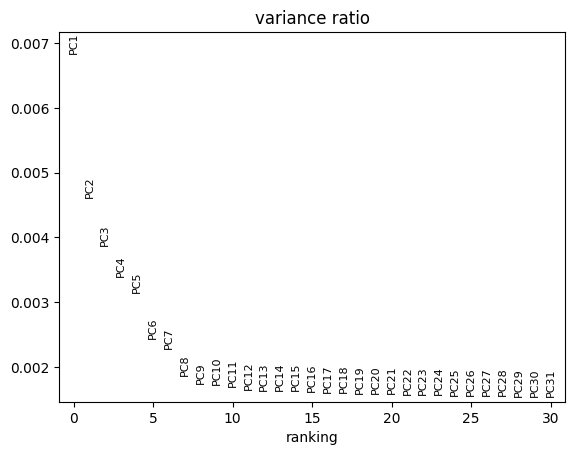

/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


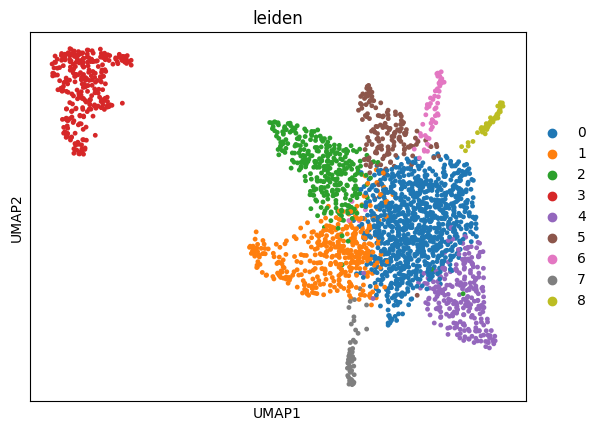

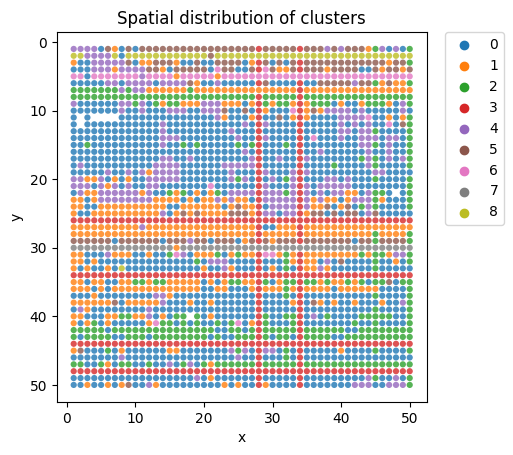

In [22]:
# see https://scanpy-tutorials.readthedocs.io/en/latest/tutorial_pearson_residuals.html
rna_ad = sc.AnnData(X=rna.values.copy(), obs=rna.index.to_frame(name="id").copy(), var=rna.columns.to_frame(name="gene").copy(), obsm={"spatial": spatial.copy()})
print(rna_ad)

# filter
sc.pp.filter_genes(rna_ad, min_cells=100)
print(rna_ad)

# hvg
sc.experimental.pp.highly_variable_genes(
    rna_ad, flavor="pearson_residuals", n_top_genes=2500
)
rna_ad = rna_ad[:, rna_ad.var["highly_variable"]]
print(rna_ad)

# normalize
rna_ad.layers["raw"] = rna_ad.X.copy()
rna_ad.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(rna_ad, inplace=False)["X"]
)
sc.experimental.pp.normalize_pearson_residuals(rna_ad, theta=100)

# pca
sc.pp.pca(rna_ad, n_comps=50)
sc.pl.pca_variance_ratio(rna_ad)

# clustering and umap
sc.pp.neighbors(rna_ad, n_neighbors=20, n_pcs=10)
sc.tl.umap(rna_ad)
sc.tl.leiden(rna_ad, resolution=0.5)
sc.pl.umap(rna_ad, color=["leiden"])

# plot spatial
plot_df = rna_ad.obsm["spatial"].copy()
plot_df["marker"] = rna_ad.obs["leiden"].values
sns.scatterplot(data=plot_df, x="x", y="y", hue="marker", s=20, alpha=0.8)
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("Spatial distribution of clusters")
plt.show()

AnnData object with n_obs × n_vars = 2492 × 28388
    obs: 'id'
    var: 'gene'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2492 × 10087
    obs: 'id'
    var: 'gene', 'n_cells'
    obsm: 'spatial'


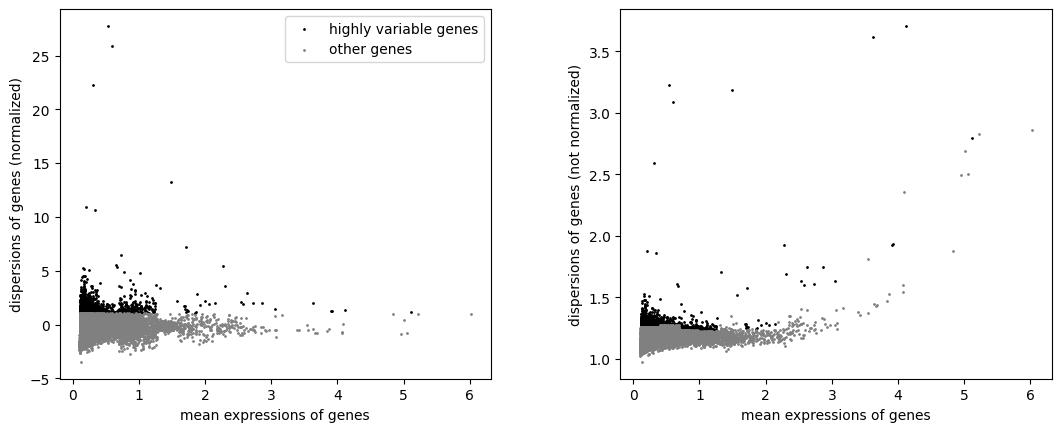

View of AnnData object with n_obs × n_vars = 2492 × 1000
    obs: 'id'
    var: 'gene', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'


/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.


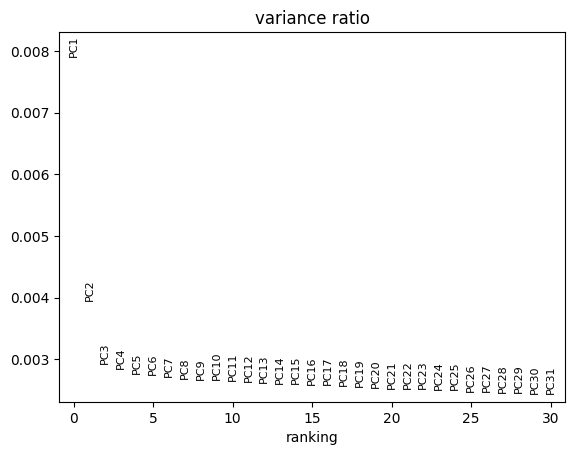

AnnData object with n_obs × n_vars = 2492 × 1000
    obs: 'id'
    var: 'gene', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'


/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


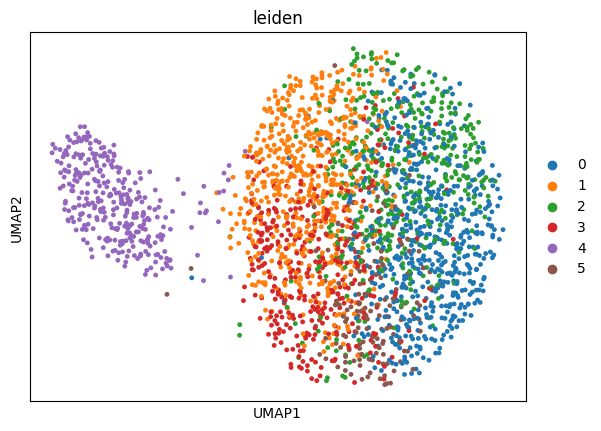

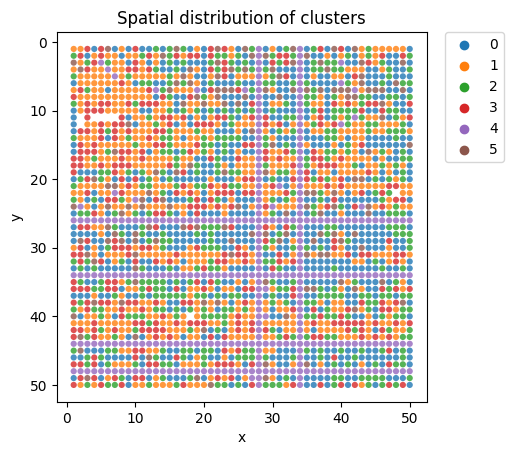

In [15]:
rna_ad = sc.AnnData(X=rna.values.copy(), obs=rna.index.to_frame(name="id").copy(), var=rna.columns.to_frame(name="gene").copy(), obsm={"spatial": spatial.copy()})
print(rna_ad)

# filter
sc.pp.filter_genes(rna_ad, min_cells=100)
print(rna_ad)

# normlaize
sc.pp.normalize_total(rna_ad, target_sum=1e4)
sc.pp.log1p(rna_ad)

# get hvg
sc.pp.highly_variable_genes(rna_ad, n_top_genes=1000, flavor="seurat")
#sc.pp.highly_variable_genes(rna_ad, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(rna_ad)
rna_ad = rna_ad[:, rna_ad.var["highly_variable"]]
print(rna_ad)

# sclae and pca
sc.pp.scale(rna_ad, max_value=10)
sc.tl.pca(rna_ad, svd_solver='arpack')
sc.pl.pca_variance_ratio(rna_ad)
print(rna_ad)

# clustering
sc.pp.neighbors(rna_ad, n_neighbors=20, n_pcs=20)
sc.tl.leiden(rna_ad, resolution=0.8)
sc.tl.umap(rna_ad)
sc.pl.umap(rna_ad, color=["leiden"])

# plotting
plot_df = rna_ad.obsm["spatial"].copy()
plot_df["marker"] = rna_ad.obs["leiden"].values
sns.scatterplot(data=plot_df, x="x", y="y", hue="marker", linewidth=0, s=20, alpha=0.8)
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("Spatial distribution of clusters")
plt.show()

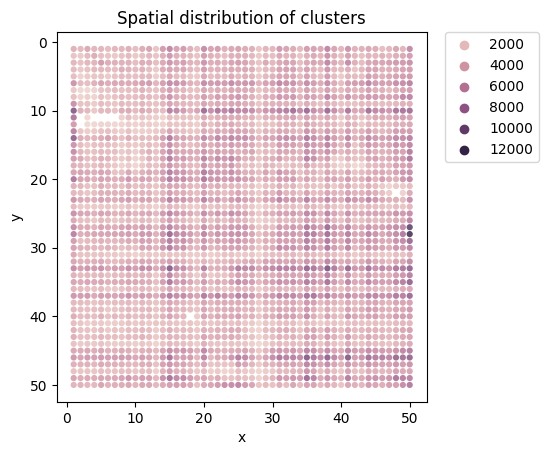

In [33]:
rna_ad = sc.AnnData(X=rna.values.copy(), obs=rna.index.to_frame(name="id").copy(), var=rna.columns.to_frame(name="gene").copy(), obsm={"spatial": spatial.copy()})

plot_df = rna_ad.obsm["spatial"].copy()
plot_df["marker"] = rna_ad.X.sum(axis=1)
sns.scatterplot(data=plot_df, x="x", y="y", hue="marker", linewidth=0, s=20, alpha=0.8)
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("Spatial distribution of clusters")
plt.show()

In [34]:
dx = {}
for x in range(rna_ad.obsm["spatial"].x.min(), rna_ad.obsm["spatial"].x.max()+1):
    dx[x] = rna_ad.obsm["spatial"].index.to_numpy()[rna_ad.obsm["spatial"].x == x]

dy = {}
for y in range(rna_ad.obsm["spatial"].y.min(), rna_ad.obsm["spatial"].y.max()+1):
    dy[y] = rna_ad.obsm["spatial"].index.to_numpy()[rna_ad.obsm["spatial"].y == y]

<Axes: >

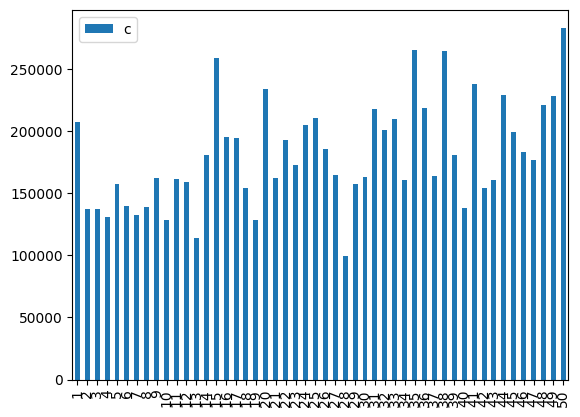

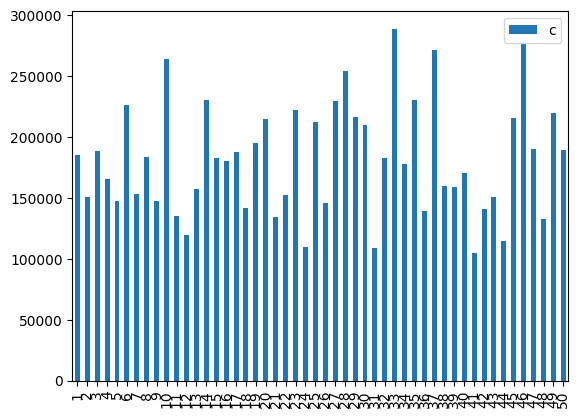

In [38]:
df_x = pd.DataFrame.from_dict({k: rna_ad[dx[k], :].X.sum().item() for k in dx.keys()}, orient='index', columns=['c'])
df_x.plot(y='c', kind="bar")

df_y = pd.DataFrame.from_dict({k: rna_ad[dy[k], :].X.sum().item() for k in dy.keys()}, orient='index', columns=['c'])
df_y.plot(y='c', kind="bar")

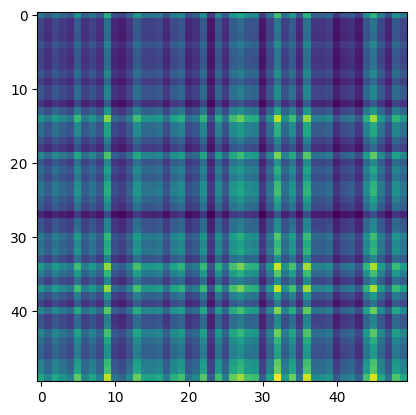

In [42]:
plt.imshow(np.outer(df_x.c, df_y.c))

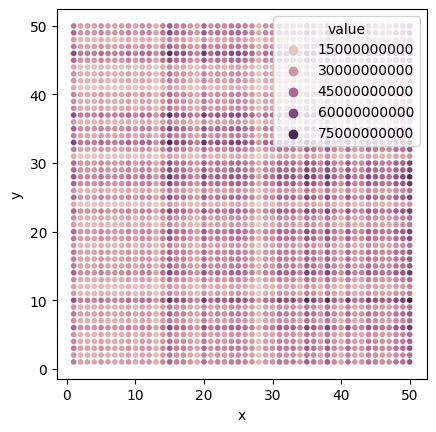

In [62]:
t = pd.DataFrame(np.outer(df_x.c, df_y.c), index=df_x.index, columns=df_y.index).reset_index().melt(id_vars='index').rename(columns={'index': 'x', 'variable': 'y'})
sns.scatterplot(data=t, x='x', y='y', hue='value', s=20)
# make x and y coord same
plt.gca().set_aspect('equal', adjustable='box')